# Detecting variable stars

This notebook starts with stacked difference images in the I- and V- bands and the V-band reference image (not a difference image) and detects variable sources.

In [2]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table, Column, join
import astropy.units as u
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks

from ccdproc import CCDData, Combiner, subtract_overscan, trim_image, create_deviation

from photutils import DAOStarFinder, CircularAperture, aperture_photometry

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullLocator

from brokenaxes import brokenaxes

## Loading the data

In [5]:
v_combined_difference = fits.getdata('../data/NGC1866_images/v_combined_difference.fits')
i_combined_difference = fits.getdata('../data/NGC1866_images/i_combined_difference.fits')

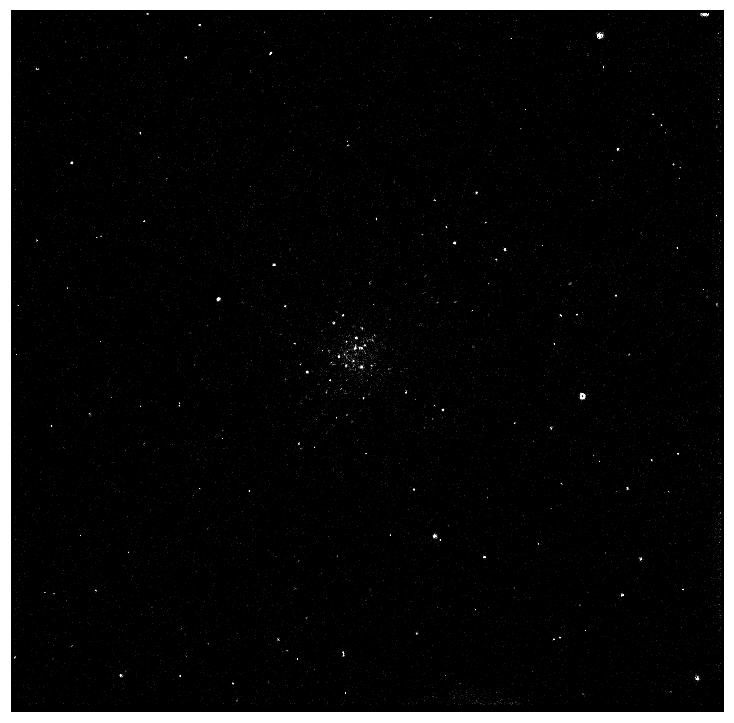

In [9]:
# V-band

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(v_combined_difference, cmap='gray',vmin=1,vmax=5)

fig.savefig("../doc/plots/v_difference_img.pdf")

plt.show()

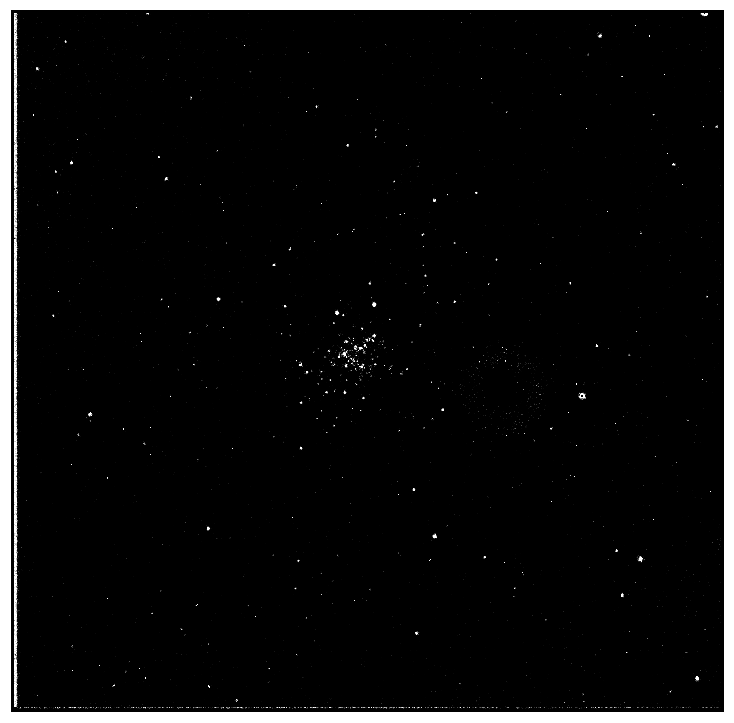

In [11]:
# I-band

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(i_combined_difference, cmap='gray',vmin=3,vmax=9)

#fig.savefig("../doc/plots/i_difference_img.pdf")

plt.show()

## Finding sources in each image

I will use Daofind to make a catalog of sources for each image. At this stage I do not cross correlate with a lis of actual stars, but potentially I will want to cross correlate with both bands and the template to get a canoncial catalog.

Using ds9 and imexamin I determined that I should use a FWHM of 5 for the source detection.

#### V-band

In [13]:
v_img_mean, v_img_median, v_img_std = sigma_clipped_stats(v_combined_difference, sigma=3.0, maxiters=5)

In [14]:
v_daofind = DAOStarFinder(fwhm=5, threshold=15*v_img_std)
v_img_catalog = v_daofind(v_combined_difference - v_img_median)
print(len(v_img_catalog))

146


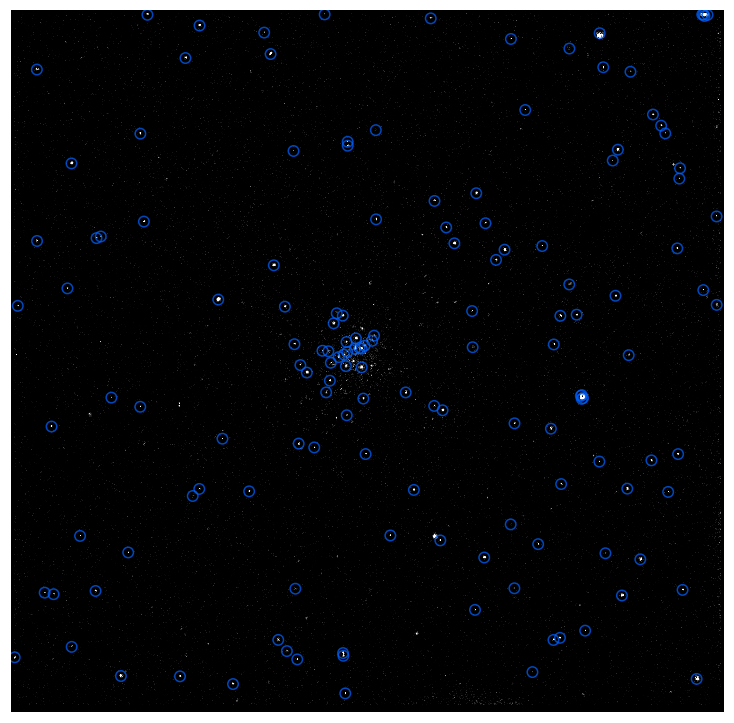

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(v_combined_difference, cmap='gray',vmin=1,vmax=5)

positions = (v_img_catalog['xcentroid'], v_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='#0061ff', lw=1.5, alpha=0.75)

plt.savefig("../doc/plots/stacked_img_with_detections_v.pdf")

#### I-band

In [16]:
i_img_mean, i_img_median, i_img_std = sigma_clipped_stats(i_combined_difference, sigma=3.0, maxiters=5)

In [17]:
i_daofind = DAOStarFinder(fwhm=5, threshold=15*i_img_std)
i_img_catalog = i_daofind(i_combined_difference - i_img_median)
print(len(i_img_catalog))

276


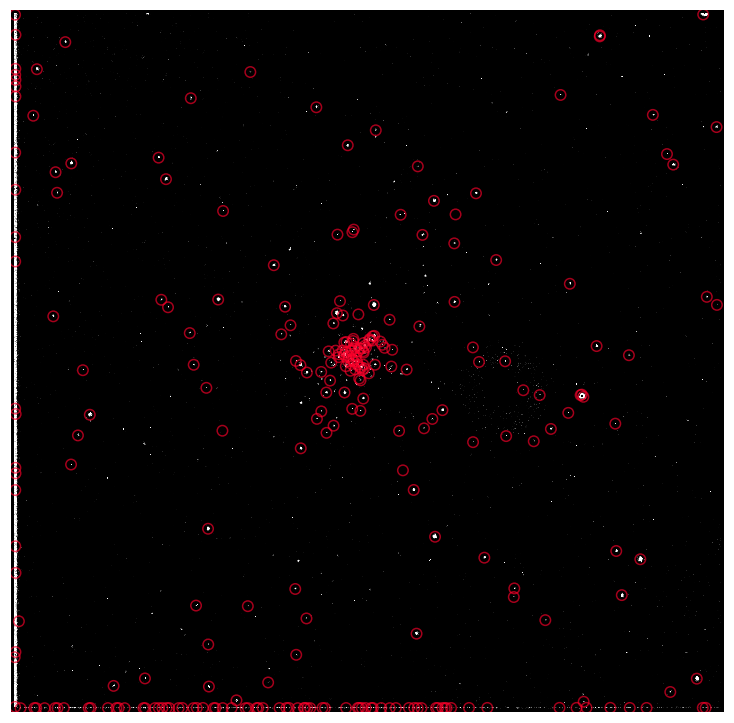

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(i_combined_difference, cmap='gray',vmin=3,vmax=9)

positions = (i_img_catalog['xcentroid'], i_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='#ff002b', lw=1.5, alpha=0.65)

plt.savefig("../doc/plots/stacked_img_with_detections_i.pdf")

#### Getting "canonical" sources from the v-template image

In [19]:
v_template_img = fits.getdata("../data/NGC1866_images/v_mean_template_crr.fits")

In [20]:
t_img_mean, t_img_median, t_img_std = sigma_clipped_stats(v_template_img, sigma=3.0, maxiters=5)

In [21]:
t_daofind = DAOStarFinder(fwhm=5, threshold=15*t_img_std)
t_img_catalog = t_daofind(v_template_img - t_img_median)
print(len(t_img_catalog))

1360


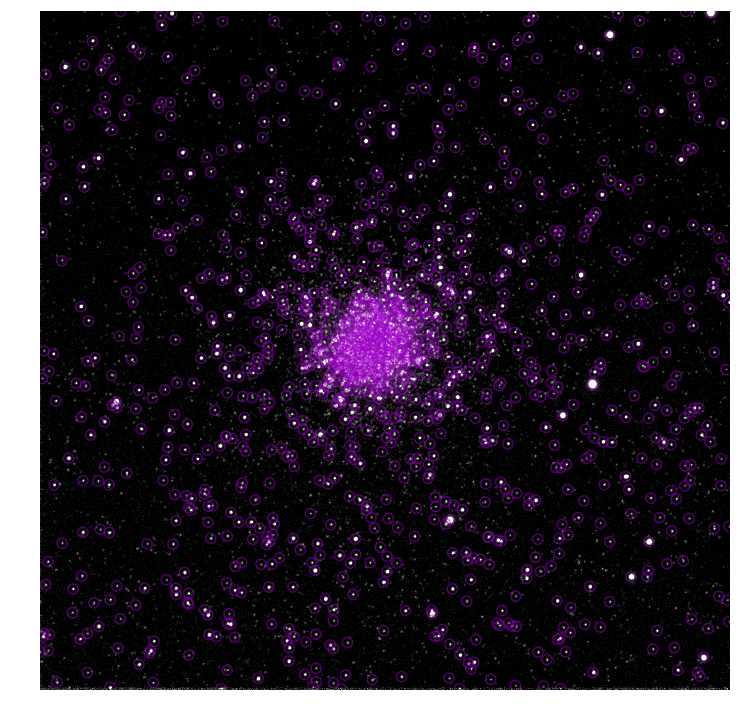

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.axis('off')

ax.imshow(v_template_img, cmap='gray',vmin=3,vmax=15)

positions = (t_img_catalog['xcentroid'], t_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='#9d00c6', lw=1.5, alpha=0.5)

fig.tight_layout(pad=0)
plt.show()

#### Plotting the V-band (blue) and I-band (red) detections together

The purple splots with the black dots in the middle should be the true variables.

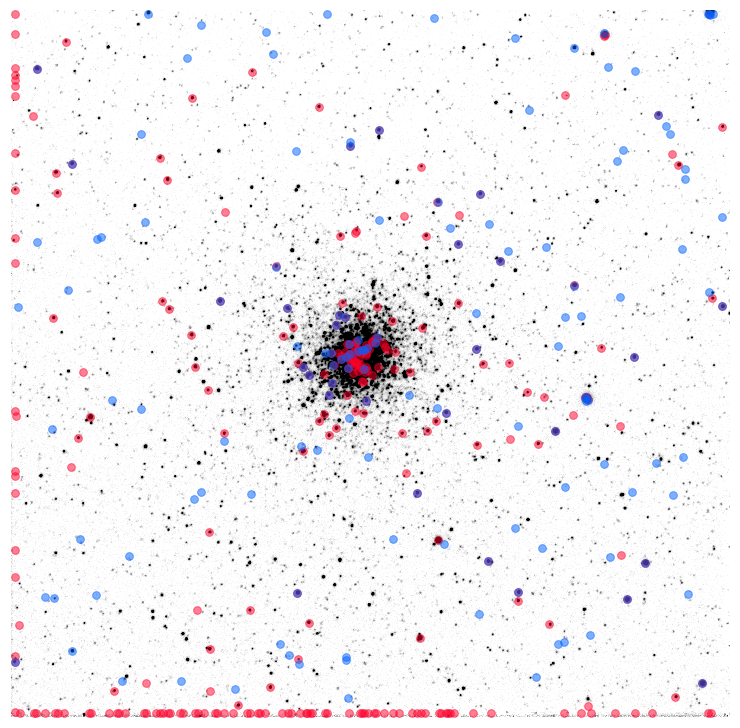

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())

ax.imshow(v_template_img, cmap='gray_r',vmin=3,vmax=15)

ax.scatter(i_img_catalog['xcentroid'], i_img_catalog['ycentroid'],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#ff002b')

ax.scatter(v_img_catalog['xcentroid'], v_img_catalog['ycentroid'],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#0061ff')

ax.set_xlim(0,v_template_img.shape[1])
ax.set_ylim(v_template_img.shape[0],0)

fig.tight_layout(pad=0)
fig.savefig("../doc/plots/detections_withfalsepos.pdf")

plt.show()

### Catalog matching

We'll need the template catalog, which will have far more stars, since it doesn't just include the variables. We will use the v_template for this, but we could use either.

In [27]:
v_wcs = WCS("../data/NGC1866_images/v_mean_template_crr.fits")
ras,decs = v_wcs.all_pix2world(t_img_catalog['xcentroid'],t_img_catalog['ycentroid'],0)
t_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')
print(f"Number of stars in the template catalog: {len(t_img_catalog)}")

Number of stars in the template catalog: 1360


#### V band
Getting the catalog and performing the crossmatch

In [28]:
ras,decs = v_wcs.all_pix2world(v_img_catalog['xcentroid'],v_img_catalog['ycentroid'],0)
v_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')

In [29]:
idx_v, d2d_v, d3d_v = v_img_catalog['coord'].match_to_catalog_sky(t_img_catalog['coord'])

In [30]:
v_crossmatch_table = Table(names=["x_v","y_v","t_id","v_dist"],
                           data=[v_img_catalog['xcentroid'].data, v_img_catalog['ycentroid'].data, idx_v, d2d_v])

In [31]:
mask = np.array([False]*len(v_crossmatch_table))

for t_id in np.unique(v_crossmatch_table['t_id']):
    if sum(v_crossmatch_table['t_id']==t_id) == 1:
        continue
    mask += ((v_crossmatch_table['t_id']==t_id) & 
             (v_crossmatch_table['v_dist'] != v_crossmatch_table[v_crossmatch_table['t_id']==t_id]['v_dist'].min()))

In [32]:
v_crossmatch_table = v_crossmatch_table[~mask]

#### I band
Getting the catalog and performing the crossmatch

In [33]:
i_wcs = WCS("../data/NGC1866_images/i_mean_template_crr.fits")
ras,decs = v_wcs.all_pix2world(i_img_catalog['xcentroid'],i_img_catalog['ycentroid'],0)
i_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')

In [34]:
idx_i, d2d_i, d3d_i = i_img_catalog['coord'].match_to_catalog_sky(t_img_catalog['coord'])

In [35]:
i_crossmatch_table = Table(names=["x_i","y_i","t_id","i_dist"],
                           data=[i_img_catalog['xcentroid'].data, i_img_catalog['ycentroid'].data, idx_i, d2d_i])

In [36]:
mask = np.array([False]*len(i_crossmatch_table))

for t_id in np.unique(i_crossmatch_table['t_id']):
    if sum(i_crossmatch_table['t_id']==t_id) == 1:
        continue
    mask += ((i_crossmatch_table['t_id']==t_id) & 
             (i_crossmatch_table['i_dist'] != i_crossmatch_table[i_crossmatch_table['t_id']==t_id]['i_dist'].min()))

In [37]:
i_crossmatch_table = i_crossmatch_table[~mask]

#### Putting together the full crossmatch table

In [38]:
full_crossmatch_table = join(v_crossmatch_table,i_crossmatch_table,"t_id")

In [39]:
full_crossmatch_table.add_column(Column(name="x_t",data=t_img_catalog['xcentroid'][full_crossmatch_table['t_id']]))
full_crossmatch_table.add_column(Column(name="y_t",data=t_img_catalog['ycentroid'][full_crossmatch_table['t_id']]))

Plotting the sources and removing the ones that are still bad.

In [40]:
mask = (full_crossmatch_table['v_dist'] < .0005) & (full_crossmatch_table['i_dist'] < .0005)

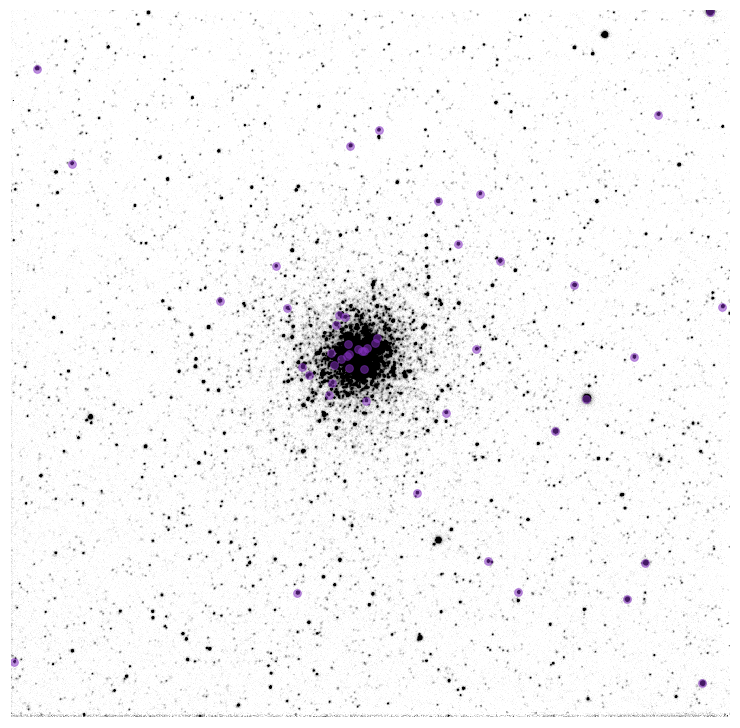

In [41]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())

ax.imshow(v_template_img, cmap='gray_r',vmin=3,vmax=15)

ax.scatter(full_crossmatch_table['x_t'][mask], full_crossmatch_table['y_t'][mask],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#8932c8')

ax.set_xlim(0,v_template_img.shape[1])
ax.set_ylim(v_template_img.shape[0],0)

fig.tight_layout(pad=0)
fig.savefig("../doc/plots/detections.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [42]:
full_crossmatch_table = full_crossmatch_table[mask]

In [43]:
print(f"Number of sources in both the I and V band difference images and the template image: {len(full_crossmatch_table)}")

Number of sources in both the I and V band difference images and the template image: 50


#### Saving the crossmatch table

In [45]:
full_crossmatch_table.add_column(Column(name="id",data=list(range(1,len(full_crossmatch_table)+1))))

In [46]:
full_crossmatch_table.write("../data/NGC1866_data_tables/variable_star_parameter_table_no_period.ecsv",
                            format="ascii.ecsv", overwrite=True)